# TODOS (Design):

1. Create the list of functions
2. Generate the Clean and Dirty datasets
3. Train on Clean and Dirty datasets
4. Repeat (3) for different activation functions (Tanh, Sigmoid, ReLU, PReLU, etc...)
5. For each function, create a figure depicting each model's predictions vs the real value
6. Compare the figures from (5) to see which activation functions performed better

# Importing Packages

In [19]:
import numpy as np
import math
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler

# Defining Configuration

In [20]:
config = {
    'max_epochs': 20,
    'batch_size': 64,
    'lr': 0.001,
    'weight_decay': 1e-10,
    'num_cols': 10,
}

# Generate the Clean and Dirty Datasets

### Create the list of functions

In [21]:
class DatasetFactory:
    def __init__(self, domain, dirty_frac=0.1, cols=config['num_cols']):
        # TODO: Create the list of functions
        C = 2 * np.random.random_sample(11) - 1  # constants
        self.funcs = [
            lambda x : C[0] * math.sin(x),
            lambda x : C[1] * math.cos(x), 
            lambda x: C[2] * x + C[3],
            lambda x: C[4] * x**2 + C[5] * x + C[6],
            lambda x: C[7] * x**3 + C[8] * x**2 + C[9] * x + C[10],
            # lambda x: 0 if x == 0 else math.sin(1/x),
            # lambda x: math.e ** x,
        ]
        if cols < len(self.funcs):
            self.funcs = self.funcs[0:cols]
        while cols > len(self.funcs):
            self.funcs.append(random.choice(self.funcs))
            # f, g = random.choices(self.funcs, k=2)
            # rand_operation = random.randint(0, 1)
            # if (rand_operation == 0):
            #     self.funcs.append(lambda x: f(x) * g(x))
            # elif (rand_operation == 1): 
            #     self.funcs.append(lambda x: f(g(x)))
            # else:
            #     continue

        
        columns = []
        for j in range(cols):
            np.random.shuffle(domain)
            columns.append(domain.tolist())

        self.X_trans_clean = []
        self.X_clean = []
        for i in range(len(columns[0])):
            row = []
            row_trans = []
            for j in range(len(columns)):
                row.append(columns[j][i])
                # row_trans.append(columns[j][i])
                # f = self.funcs[j % len(self.funcs)]
                # row_trans.append(f(columns[j][i]))
                # print(columns[j][i])
                row_trans.append(self.funcs[j](columns[j][i]))
            self.X_clean.append(row)
            self.X_trans_clean.append(row_trans)
            
        # Transforming lists into arrays and standardizing
        self.X_clean = np.array(self.X_clean, dtype=float)
        self.X_trans_clean = np.array(self.X_trans_clean, dtype=float)
        self.X_clean = StandardScaler().fit_transform(self.X_clean)
        self.X_trans_clean = StandardScaler().fit_transform(self.X_trans_clean)
        self.y_clean = np.mean(self.X_trans_clean, axis=1)

        # Create the dirty data by adding Gaussian noise to a portion of the clean_data
        noise = np.random.normal(loc=0, scale=0.5, size=(math.floor(dirty_frac * self.X_clean.shape[0]), self.X_clean.shape[1] + 1))
        no_noise = np.zeros(shape=(math.ceil((1 - dirty_frac) * self.X_clean.shape[0]), self.X_clean.shape[1] + 1))
        self.offset = np.concatenate((noise, no_noise))
        np.random.shuffle(self.offset)
        self.X_dirty = self.X_clean + self.offset[:, 0:self.X_clean.shape[1]]
        self.X_trans_dirty = self.X_trans_clean + self.offset[:, 0:self.X_clean.shape[1]]
        self.y_dirty = self.y_clean + self.offset[:, self.X_clean.shape[1]]

    def get_clean(self):
        return self.X_clean, self.y_clean
    
    def get_dirty(self):
        return self.X_dirty, self.y_dirty
    
    def get_trans(self):
        return self.X_trans_clean, self.X_trans_dirty
    
    def get_offset(self):
        return self.offset
    
    def get_funcs(self):
        return self.funcs

In [22]:
domain = np.arange(-875, 875, 0.25, dtype=float)
dataFactory = DatasetFactory(domain.copy())
X_clean, y_clean = dataFactory.get_clean()
print(X_clean.shape, y_clean.shape)
X_dirty, y_dirty = dataFactory.get_dirty()
X_trans_clean, X_trans_dirty = dataFactory.get_trans()

offset = dataFactory.get_offset()

(7000, 10) (7000,)


In [23]:
def display_function(domain, offset, f_i, title=''):
    func = dataFactory.get_funcs()[f_i]
    y_clean = np.apply_along_axis(func, 0, domain)
    y_clean = (y_clean - y_clean.mean()) / y_clean.std()
    domain = (domain - domain.mean()) / domain.std()
    y_dirty = y_clean + offset[:, f_i]
    figure(figsize=(6, 4))
    plt.plot(domain, y_dirty, c='tab:cyan', label='dirty')
    plt.plot(domain, y_clean, c='tab:red', label='clean')
    plt.ylim(min(np.min(y_clean), np.min(y_dirty)), max(np.max(y_clean), np.max(y_dirty)))
    plt.xlabel('domain')
    plt.ylabel('target')
    plt.title(title)
    plt.legend()
    plt.show()

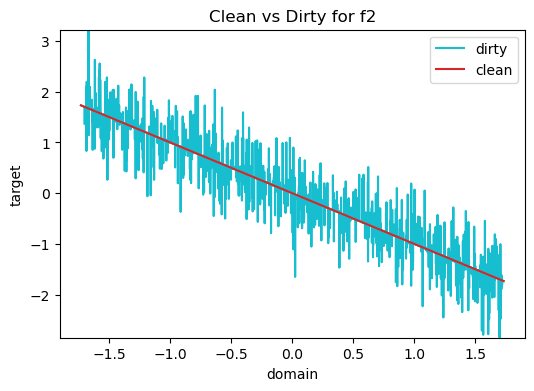

In [24]:
display_function(domain.copy(), offset, 2, 'Clean vs Dirty for f2')

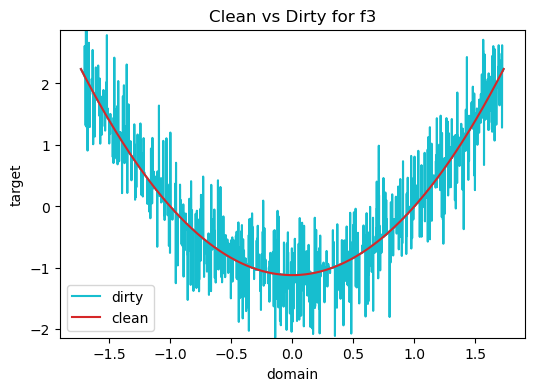

In [25]:
display_function(domain.copy(), offset, 3, 'Clean vs Dirty for f3')

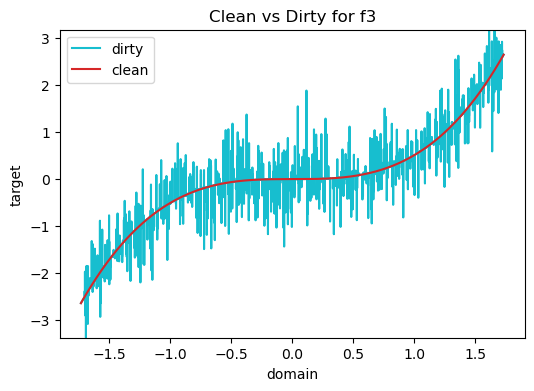

In [26]:
display_function(domain.copy(), offset, 4, 'Clean vs Dirty for f3')  

# Data Preprocessing

### Splitting into train and val

In [27]:
from sklearn.model_selection import train_test_split

X_train_clean, X_val, y_train_clean, y_val = train_test_split(X_clean, y_clean, test_size=2/7)
X_train_dirty, X_val_dirty, y_train_dirty, y_val_dirty = train_test_split(X_dirty, y_dirty, test_size=2/7)

### Creating Dataset

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader

In [29]:
class CustomDataset(Dataset):
    def __init__(self, X, y, mode):
        super(CustomDataset, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
        
        self.dim = self.X.shape[0]
        print('Finished reading the {} set of Dataset ({} samples found, each dim = {})'.format(mode, len(self.X), self.dim))
        print(f"\tX.shape, X.dtype = {self.X.shape}, {self.X.dtype}")
        print(f"\ty.shape, y.dtype = {self.y.shape}, {self.y.dtype}")


    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [30]:
trainset_clean = CustomDataset(X_train_clean, y_train_clean, mode='train')
trainset_dirty = CustomDataset(X_train_dirty, y_train_dirty, mode='train')
valset = CustomDataset(X_val, y_val, mode='val')

Finished reading the train set of Dataset (5000 samples found, each dim = 5000)
	X.shape, X.dtype = torch.Size([5000, 10]), torch.float32
	y.shape, y.dtype = torch.Size([5000, 1]), torch.float32
Finished reading the train set of Dataset (5000 samples found, each dim = 5000)
	X.shape, X.dtype = torch.Size([5000, 10]), torch.float32
	y.shape, y.dtype = torch.Size([5000, 1]), torch.float32
Finished reading the val set of Dataset (2000 samples found, each dim = 2000)
	X.shape, X.dtype = torch.Size([2000, 10]), torch.float32
	y.shape, y.dtype = torch.Size([2000, 1]), torch.float32


### Creating Dataloader

In [31]:
train_loader_clean = DataLoader(trainset_clean, batch_size=config['batch_size'], shuffle=True)
train_loader_dirty = DataLoader(trainset_dirty, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(valset, batch_size=config['batch_size'], shuffle=False)

# Defining the Model

In [32]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(device)

device(type='cuda')

In [33]:
# TODO: Tune this model architecture
class Net(nn.Module):
    def __init__(self, activation_function, d_in=config['num_cols'], d_out=1):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 128),
            nn.BatchNorm1d(128),
            activation_function(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            activation_function(),
            nn.Linear(64, d_out),
        )

        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        return self.net(x)

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

# Training

In [34]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from copy import deepcopy

# Testing
from sklearn.metrics import accuracy_score

In [35]:
def train(model, train_loader, val_loader, valset, optimizer=None):
    best_val_loss = 10000
    best_val_model = None
    loss_record = {'train': [], 'val': []}
    if optimizer is None:
        optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    for epoch in range(config['max_epochs']):
        running_loss = 0.0
        running_size = 0
        # this shows a progress bar during training, which is valuable due to how long it takes to train
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = model.cal_loss(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_size += data.size(0)
            loss_record['train'].append(running_loss/running_size)
        
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for data, target in val_loader:
                out = model(data.to(device)).cpu()
                val_loss += model.cal_loss(out, target).item()

        # this fixes the problem where val_set is off by one during plotting
        loss_record['val'].append(val_loss/len(valset))
        # Just print out the validation accuracy because it doesn't get updated repeatedly like how training accuracy does
        if val_loss/len(valset) < best_val_loss:
            best_val_loss = val_loss / len(valset)
            best_val_model = deepcopy(model.state_dict())
            print("Epoch {0:>2}: train loss={1:<10f} | val loss={2:<10f}".format(epoch+1, running_loss/running_size, val_loss/len(valset)))
    print('Finished Training')
    return loss_record, best_val_model

In [36]:
relu_loss_record_clean, relu_best_model_clean = train(Net(nn.ReLU).to(device), train_loader_clean, val_loader, valset)

Epoch  1: train loss=0.001173   | val loss=0.000939  
Epoch  2: train loss=0.000810   | val loss=0.000824  
Epoch  3: train loss=0.000751   | val loss=0.000777  
Epoch  5: train loss=0.000691   | val loss=0.000765  
Epoch  8: train loss=0.000678   | val loss=0.000760  
Epoch 13: train loss=0.000653   | val loss=0.000757  
Epoch 15: train loss=0.000617   | val loss=0.000747  
Finished Training


In [37]:
relu_loss_record_dirty, relu_best_model_dirty = train(Net(nn.ReLU).to(device), train_loader_dirty, val_loader, valset)

Epoch  1: train loss=0.001665   | val loss=0.000870  
Epoch  2: train loss=0.001274   | val loss=0.000771  
Epoch  3: train loss=0.001215   | val loss=0.000734  
Epoch  4: train loss=0.001161   | val loss=0.000732  
Epoch  7: train loss=0.001092   | val loss=0.000710  
Epoch  8: train loss=0.001113   | val loss=0.000692  
Epoch  9: train loss=0.001069   | val loss=0.000690  
Epoch 10: train loss=0.001058   | val loss=0.000681  
Epoch 14: train loss=0.001020   | val loss=0.000675  
Finished Training


In [38]:
lrelu_loss_record_clean, lrelu_best_model_clean = train(Net(nn.LeakyReLU).to(device), train_loader_clean, val_loader, valset)

Epoch  1: train loss=0.001326   | val loss=0.000889  
Epoch  2: train loss=0.000865   | val loss=0.000803  
Epoch  3: train loss=0.000798   | val loss=0.000794  
Epoch  4: train loss=0.000737   | val loss=0.000775  
Epoch  5: train loss=0.000746   | val loss=0.000760  
Epoch  6: train loss=0.000710   | val loss=0.000748  
Epoch 10: train loss=0.000659   | val loss=0.000745  
Epoch 15: train loss=0.000627   | val loss=0.000740  
Finished Training


In [39]:
lrelu_loss_record_dirty, lrelu_best_model_dirty = train(Net(nn.LeakyReLU).to(device), train_loader_dirty, val_loader, valset)

Epoch  1: train loss=0.001634   | val loss=0.000862  
Epoch  2: train loss=0.001264   | val loss=0.000787  
Epoch  3: train loss=0.001193   | val loss=0.000731  
Epoch  4: train loss=0.001142   | val loss=0.000716  
Epoch  5: train loss=0.001142   | val loss=0.000708  
Epoch  8: train loss=0.001065   | val loss=0.000698  
Epoch  9: train loss=0.001093   | val loss=0.000697  
Epoch 11: train loss=0.001061   | val loss=0.000682  
Epoch 14: train loss=0.001015   | val loss=0.000662  
Epoch 20: train loss=0.001001   | val loss=0.000654  
Finished Training


In [40]:
prelu_loss_record_clean, prelu_best_model_clean = train(Net(nn.PReLU).to(device), train_loader_clean, val_loader, valset)

Epoch  1: train loss=0.001216   | val loss=0.000822  
Epoch  2: train loss=0.000844   | val loss=0.000821  
Epoch  3: train loss=0.000788   | val loss=0.000768  
Epoch  4: train loss=0.000765   | val loss=0.000745  
Epoch  7: train loss=0.000732   | val loss=0.000736  
Finished Training


In [41]:
prelu_loss_record_dirty, prelu_best_model_dirty = train(Net(nn.PReLU).to(device), train_loader_dirty, val_loader, valset)

Epoch  1: train loss=0.001639   | val loss=0.000964  
Epoch  2: train loss=0.001354   | val loss=0.000780  
Epoch  4: train loss=0.001233   | val loss=0.000762  
Epoch  5: train loss=0.001204   | val loss=0.000756  
Epoch  6: train loss=0.001157   | val loss=0.000720  
Epoch  7: train loss=0.001156   | val loss=0.000703  
Epoch 10: train loss=0.001130   | val loss=0.000689  
Epoch 14: train loss=0.001060   | val loss=0.000681  
Epoch 17: train loss=0.001013   | val loss=0.000675  
Finished Training


In [42]:
elu_loss_record_clean, elu_best_model_clean = train(Net(nn.ELU).to(device), train_loader_clean, val_loader, valset)

Epoch  1: train loss=0.001150   | val loss=0.000889  
Epoch  2: train loss=0.000851   | val loss=0.000775  
Epoch  3: train loss=0.000830   | val loss=0.000741  
Epoch  7: train loss=0.000736   | val loss=0.000726  
Epoch  8: train loss=0.000749   | val loss=0.000706  
Epoch  9: train loss=0.000726   | val loss=0.000705  
Finished Training


In [43]:
elu_loss_record_dirty, elu_best_model_dirty = train(Net(nn.ELU).to(device), train_loader_dirty, val_loader, valset)

Epoch  1: train loss=0.001731   | val loss=0.000960  
Epoch  2: train loss=0.001305   | val loss=0.000850  
Epoch  3: train loss=0.001281   | val loss=0.000778  
Epoch  4: train loss=0.001258   | val loss=0.000776  
Epoch  5: train loss=0.001245   | val loss=0.000731  
Epoch  6: train loss=0.001209   | val loss=0.000710  
Epoch 12: train loss=0.001156   | val loss=0.000705  
Epoch 20: train loss=0.001127   | val loss=0.000692  
Finished Training


In [44]:
softsign_loss_record_clean, softsign_best_model_clean = train(Net(nn.Softsign).to(device), train_loader_clean, val_loader, valset)

Epoch  1: train loss=0.001336   | val loss=0.001222  
Epoch  2: train loss=0.001204   | val loss=0.001153  
Epoch  5: train loss=0.001088   | val loss=0.001109  
Epoch  6: train loss=0.001069   | val loss=0.001086  
Epoch  7: train loss=0.001031   | val loss=0.001049  
Epoch  8: train loss=0.000977   | val loss=0.001037  
Epoch  9: train loss=0.000915   | val loss=0.000987  
Epoch 10: train loss=0.000852   | val loss=0.000935  
Epoch 11: train loss=0.000809   | val loss=0.000867  
Epoch 13: train loss=0.000753   | val loss=0.000860  
Epoch 15: train loss=0.000720   | val loss=0.000827  
Epoch 16: train loss=0.000700   | val loss=0.000826  
Epoch 17: train loss=0.000710   | val loss=0.000822  
Epoch 18: train loss=0.000661   | val loss=0.000816  
Finished Training


In [45]:
softsign_loss_record_dirty, softsign_best_model_dirty = train(Net(nn.Softsign).to(device), train_loader_dirty, val_loader, valset)

Epoch  1: train loss=0.001763   | val loss=0.001196  
Epoch  2: train loss=0.001563   | val loss=0.001164  
Epoch  3: train loss=0.001545   | val loss=0.001120  
Epoch  4: train loss=0.001481   | val loss=0.001072  
Epoch  6: train loss=0.001448   | val loss=0.001035  
Epoch  7: train loss=0.001413   | val loss=0.001008  
Epoch  8: train loss=0.001368   | val loss=0.000991  
Epoch  9: train loss=0.001347   | val loss=0.000978  
Epoch 11: train loss=0.001256   | val loss=0.000878  
Epoch 12: train loss=0.001196   | val loss=0.000828  
Epoch 13: train loss=0.001205   | val loss=0.000819  
Epoch 14: train loss=0.001132   | val loss=0.000813  
Epoch 15: train loss=0.001118   | val loss=0.000800  
Epoch 16: train loss=0.001125   | val loss=0.000785  
Epoch 18: train loss=0.001115   | val loss=0.000759  
Epoch 19: train loss=0.001056   | val loss=0.000753  
Epoch 20: train loss=0.001065   | val loss=0.000734  
Finished Training


In [46]:
sigmoid_loss_record_clean, sigmoid_best_model_clean = train(Net(nn.Sigmoid).to(device), train_loader_clean, val_loader, valset)

Epoch  1: train loss=0.001233   | val loss=0.001089  
Epoch  3: train loss=0.001148   | val loss=0.001086  
Epoch  6: train loss=0.001133   | val loss=0.001080  
Epoch  7: train loss=0.001111   | val loss=0.001059  
Epoch  9: train loss=0.001048   | val loss=0.001016  
Epoch 10: train loss=0.000987   | val loss=0.001002  
Epoch 12: train loss=0.000850   | val loss=0.000791  
Epoch 14: train loss=0.000759   | val loss=0.000763  
Epoch 16: train loss=0.000790   | val loss=0.000743  
Epoch 18: train loss=0.000730   | val loss=0.000730  
Finished Training


In [47]:
sigmoid_loss_record_dirty, sigmoid_best_model_dirty = train(Net(nn.Sigmoid).to(device), train_loader_dirty, val_loader, valset)

Epoch  1: train loss=0.001649   | val loss=0.001103  
Epoch  2: train loss=0.001621   | val loss=0.001092  
Epoch  5: train loss=0.001519   | val loss=0.001072  
Epoch  7: train loss=0.001511   | val loss=0.001069  
Epoch  8: train loss=0.001507   | val loss=0.001038  
Epoch 10: train loss=0.001461   | val loss=0.000996  
Epoch 11: train loss=0.001410   | val loss=0.000958  
Epoch 12: train loss=0.001360   | val loss=0.000938  
Epoch 13: train loss=0.001337   | val loss=0.000895  
Epoch 14: train loss=0.001247   | val loss=0.000776  
Epoch 17: train loss=0.001198   | val loss=0.000758  
Epoch 20: train loss=0.001156   | val loss=0.000732  
Finished Training


In [48]:
tanh_loss_record_clean, tanh_best_model_clean = train(Net(nn.Tanh).to(device), train_loader_clean, val_loader, valset)

Epoch  1: train loss=0.001387   | val loss=0.001187  
Epoch  2: train loss=0.001161   | val loss=0.001175  
Epoch  3: train loss=0.001158   | val loss=0.001115  
Epoch  4: train loss=0.001127   | val loss=0.001101  
Epoch  5: train loss=0.001078   | val loss=0.001058  
Epoch  7: train loss=0.000984   | val loss=0.000988  
Epoch  8: train loss=0.000912   | val loss=0.000921  
Epoch  9: train loss=0.000834   | val loss=0.000895  
Epoch 10: train loss=0.000807   | val loss=0.000847  
Epoch 11: train loss=0.000761   | val loss=0.000815  
Epoch 12: train loss=0.000753   | val loss=0.000804  
Epoch 16: train loss=0.000686   | val loss=0.000756  
Finished Training


In [49]:
tanh_loss_record_dirty, tanh_best_model_dirty = train(Net(nn.Tanh).to(device), train_loader_dirty, val_loader, valset)

Epoch  1: train loss=0.001947   | val loss=0.001159  
Epoch  3: train loss=0.001586   | val loss=0.001095  
Epoch  4: train loss=0.001520   | val loss=0.001069  
Epoch  7: train loss=0.001434   | val loss=0.001027  
Epoch  8: train loss=0.001402   | val loss=0.001015  
Epoch  9: train loss=0.001363   | val loss=0.000965  
Epoch 12: train loss=0.001258   | val loss=0.000932  
Epoch 13: train loss=0.001244   | val loss=0.000852  
Epoch 15: train loss=0.001150   | val loss=0.000797  
Epoch 17: train loss=0.001146   | val loss=0.000788  
Epoch 18: train loss=0.001149   | val loss=0.000764  
Epoch 19: train loss=0.001105   | val loss=0.000720  
Finished Training


### Plotting Learning Curve

In [50]:
from matplotlib.pyplot import figure

def plot_learning_curve(loss_record, title='', num_std_devs=3):
    ''' Plot learning curve of your DNN (train & val loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    offset = len(loss_record['train']) // len(loss_record['val'])
    x_2 = range(offset, total_steps + offset, offset)
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['val'], c='tab:cyan', label='val')
    
    y_lim_low = min(np.mean(loss_record['train']) - num_std_devs * np.std(loss_record['train']), 
                    np.mean(loss_record['val']) - num_std_devs * np.std(loss_record['val']))
    y_lim_high = max(np.mean(loss_record['train']) + num_std_devs * np.std(loss_record['train']), 
                    np.mean(loss_record['val']) + num_std_devs * np.std(loss_record['val']))
    
    plt.ylim(y_lim_low, y_lim_high)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

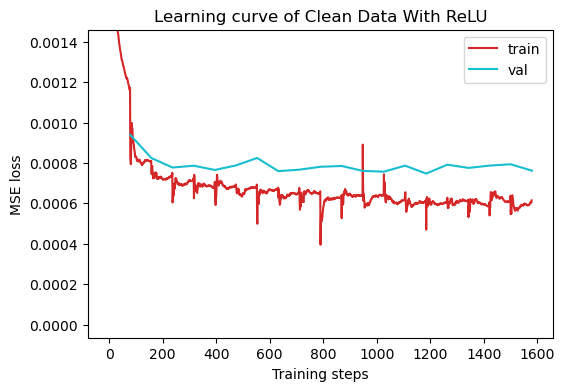

In [51]:
plot_learning_curve(relu_loss_record_clean, title="Clean Data With ReLU")

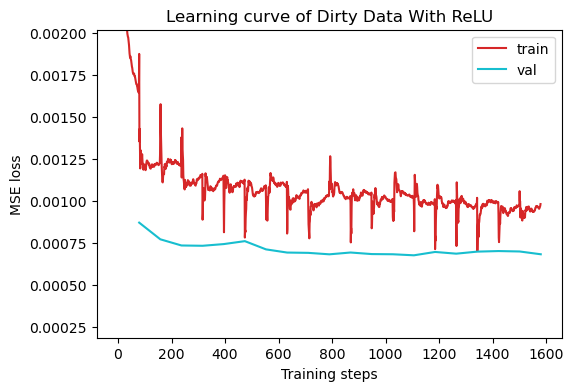

In [52]:
plot_learning_curve(relu_loss_record_dirty, title="Dirty Data With ReLU")

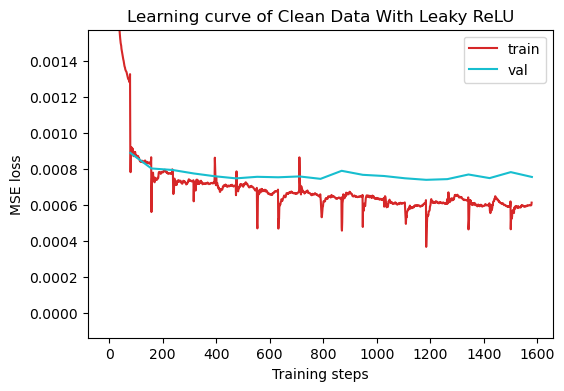

In [53]:
plot_learning_curve(lrelu_loss_record_clean, title="Clean Data With Leaky ReLU")

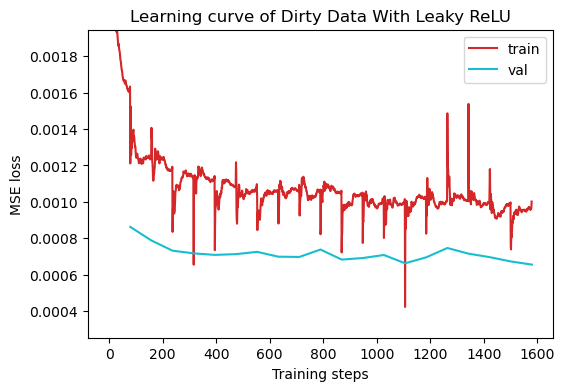

In [54]:
plot_learning_curve(lrelu_loss_record_dirty, title="Dirty Data With Leaky ReLU")

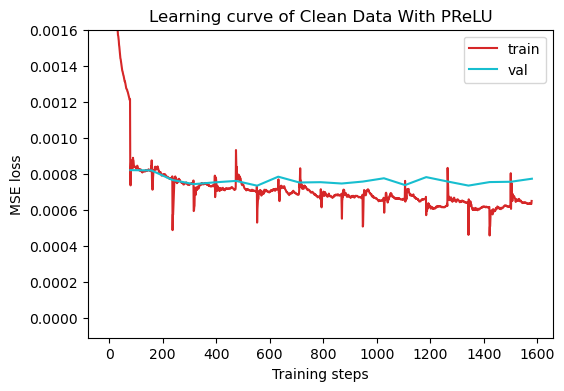

In [55]:
plot_learning_curve(prelu_loss_record_clean, title="Clean Data With PReLU")

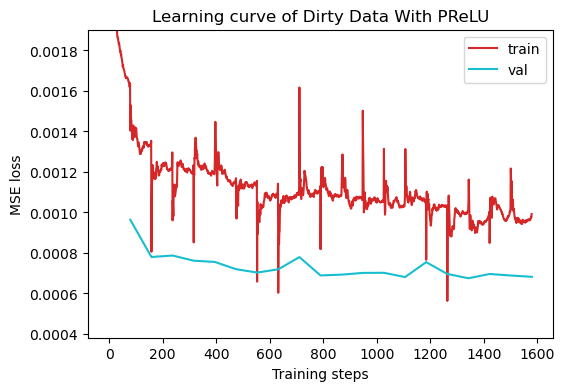

In [56]:
plot_learning_curve(prelu_loss_record_dirty, title="Dirty Data With PReLU")

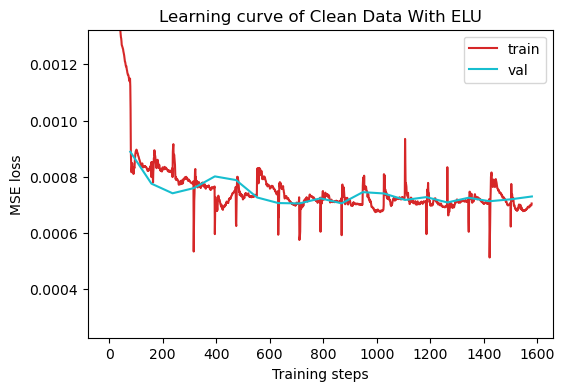

In [57]:
plot_learning_curve(elu_loss_record_clean, title="Clean Data With ELU")

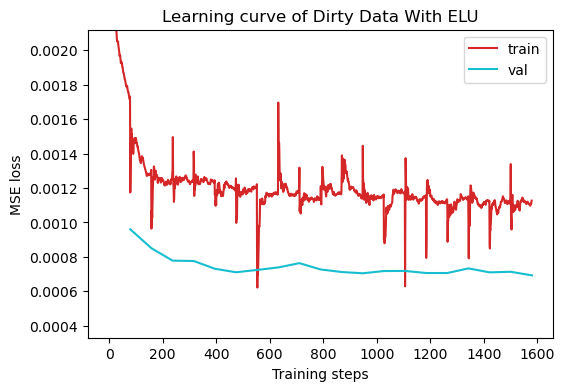

In [58]:
plot_learning_curve(elu_loss_record_dirty, title="Dirty Data With ELU")

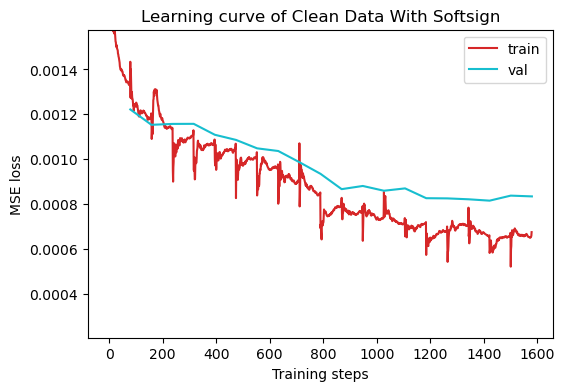

In [59]:
plot_learning_curve(softsign_loss_record_clean, title="Clean Data With Softsign")

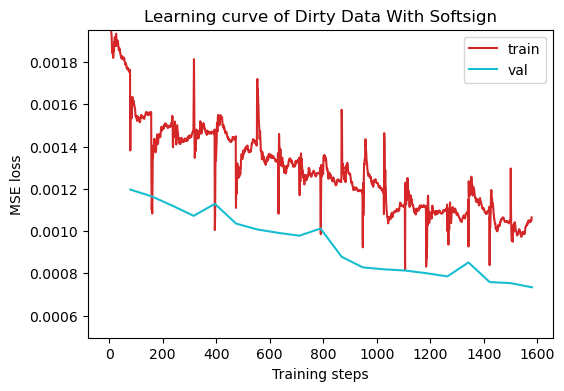

In [60]:
plot_learning_curve(softsign_loss_record_dirty, title="Dirty Data With Softsign")

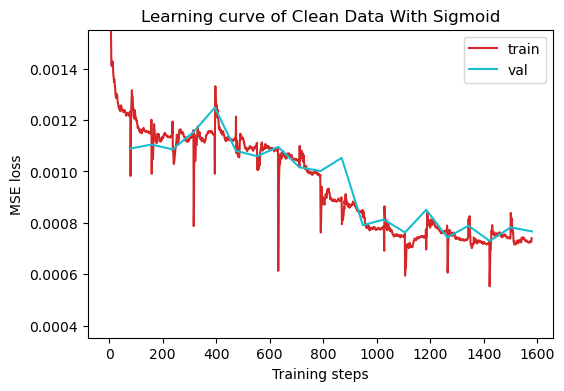

In [61]:
plot_learning_curve(sigmoid_loss_record_clean, title="Clean Data With Sigmoid")

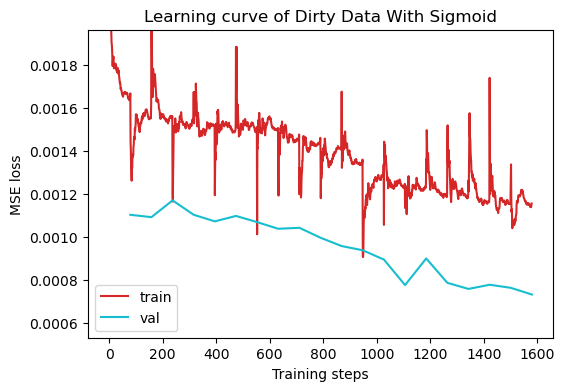

In [62]:
plot_learning_curve(sigmoid_loss_record_dirty, title="Dirty Data With Sigmoid")

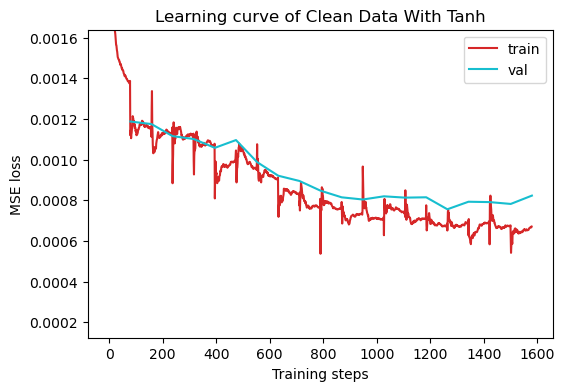

In [63]:
plot_learning_curve(tanh_loss_record_clean, title="Clean Data With Tanh")

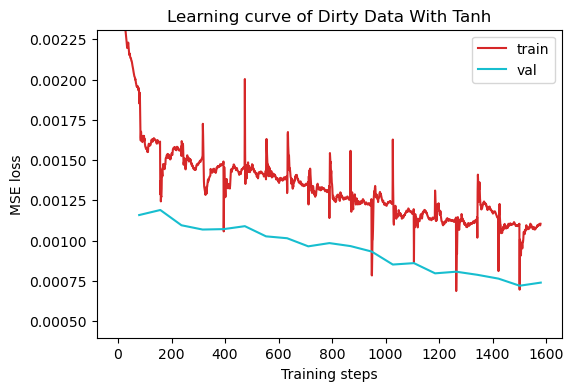

In [64]:
plot_learning_curve(tanh_loss_record_dirty, title="Dirty Data With Tanh")

# Comparing the Models

In [65]:
def plot_vals(dirty, clean, title='', num_std_devs=3):
    plt.plot(range(len(dirty)), dirty, label='dirty')
    plt.plot(range(len(clean)), clean, label='clean')
    # plt.plot(range(len(dirty)), dirty, c='tab:cyan', label='dirty')
    # plt.plot(range(len(clean)), clean, c='tab:red', label='clean')
    y_lim_low = min(np.mean(clean) - num_std_devs * np.std(clean), 
                    np.mean(dirty) - num_std_devs * np.std(dirty))
    y_lim_high = max(np.mean(clean) + num_std_devs * np.std(clean), 
                    np.mean(dirty) + num_std_devs * np.std(dirty))
    plt.ylim(y_lim_low, y_lim_high)
    plt.xlabel('Epochs')
    plt.ylabel('MSE loss')
    plt.title('Val Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

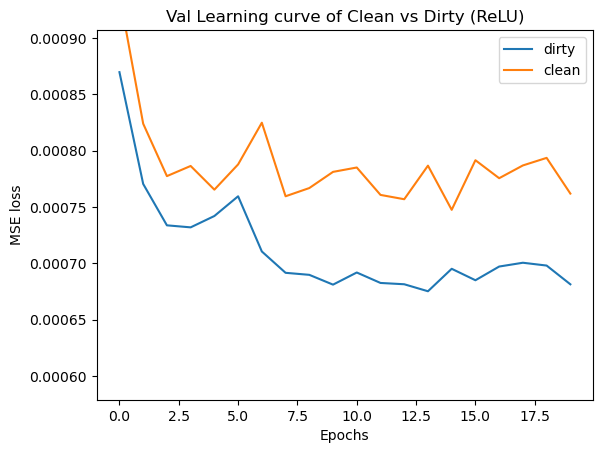

In [66]:
plot_vals(relu_loss_record_dirty['val'], relu_loss_record_clean['val'], title="Clean vs Dirty (ReLU)")

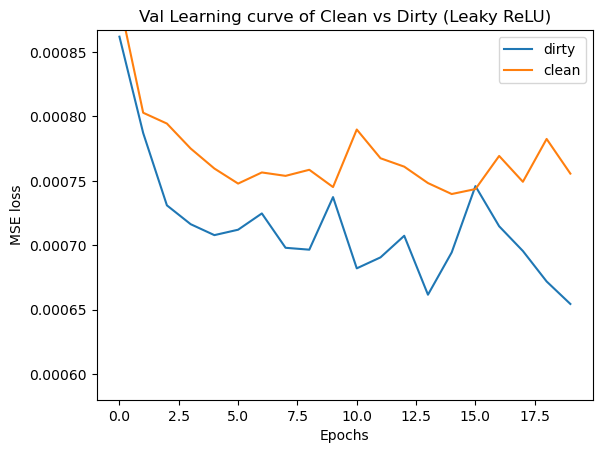

In [67]:
plot_vals(lrelu_loss_record_dirty['val'], lrelu_loss_record_clean['val'], title="Clean vs Dirty (Leaky ReLU)")

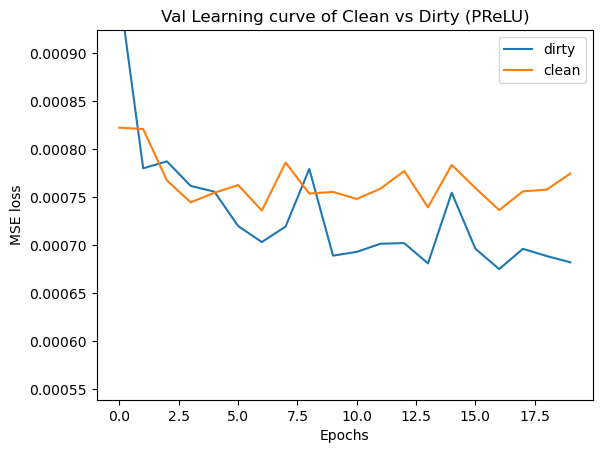

In [68]:
plot_vals(prelu_loss_record_dirty['val'], prelu_loss_record_clean['val'], title="Clean vs Dirty (PReLU)")

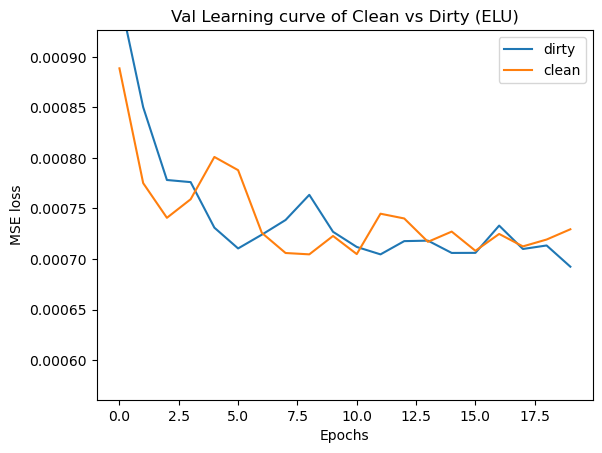

In [69]:
plot_vals(elu_loss_record_dirty['val'], elu_loss_record_clean['val'], title="Clean vs Dirty (ELU)")

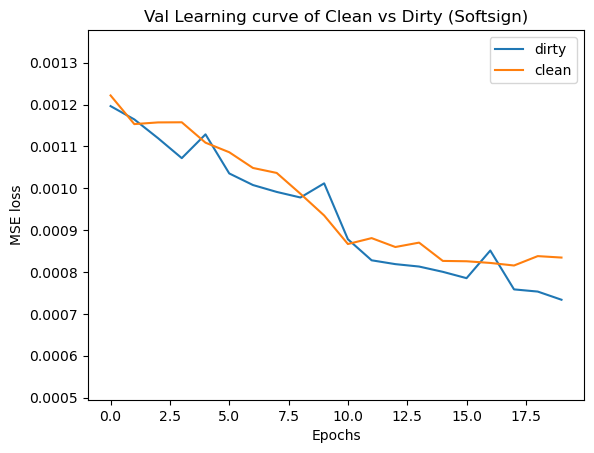

In [70]:
plot_vals(softsign_loss_record_dirty['val'], softsign_loss_record_clean['val'], title="Clean vs Dirty (Softsign)")

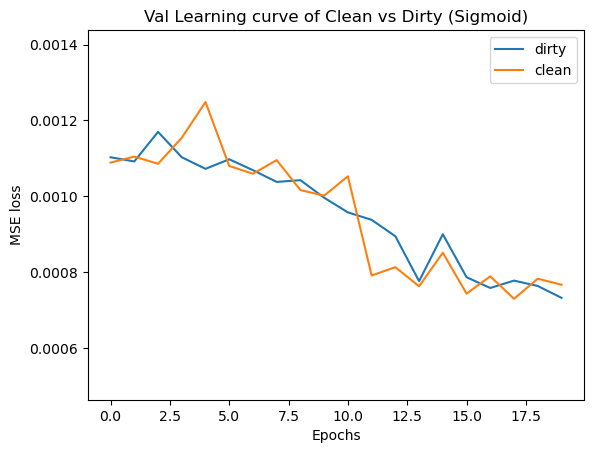

In [71]:
plot_vals(sigmoid_loss_record_dirty['val'], sigmoid_loss_record_clean['val'], title="Clean vs Dirty (Sigmoid)")

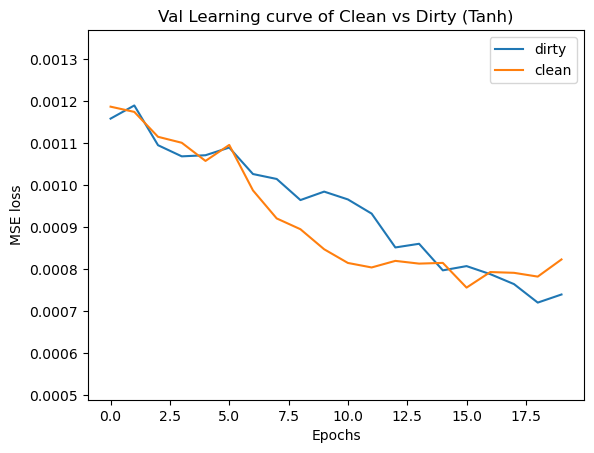

In [72]:
plot_vals(tanh_loss_record_dirty['val'], tanh_loss_record_clean['val'], title="Clean vs Dirty (Tanh)")

### Plotting Differential

In [79]:
def plot_diff(diffs, labels, title='', num_std_devs=5):
    mins = []
    maxs = []
    for i in range(len(diffs)):
        plt.plot(range(len(diffs[i])), diffs[i], label=labels[i])
        mins.append(np.mean(diffs[i]) - num_std_devs * np.std(diffs[i]))
        maxs.append(np.mean(diffs[i]) + num_std_devs * np.std(diffs[i]))
    plt.ylim(min(mins), max(maxs))
    plt.xlabel('Training steps')
    plt.ylabel('Dirty MSE Loss - Clean MSE Loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [80]:
def list_diff(list1, list2):
    answer = []
    for i in range(len(list1)):
        answer.append(list1[i] - list2[i])
    return answer

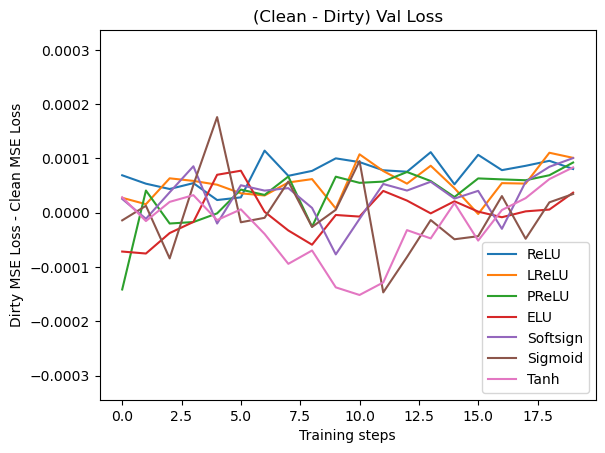

In [81]:
DIFF_relu_lrd = list_diff( relu_loss_record_clean['val'], relu_loss_record_dirty['val'])
DIFF_lrelu_lrd = list_diff(lrelu_loss_record_clean['val'], lrelu_loss_record_dirty['val'])
DIFF_prelu_lrd = list_diff(prelu_loss_record_clean['val'], prelu_loss_record_dirty['val'])
DIFF_elu_lrd = list_diff(elu_loss_record_clean['val'], elu_loss_record_dirty['val'])
DIFF_softsign_lrd = list_diff(softsign_loss_record_clean['val'], softsign_loss_record_dirty['val'])
DIFF_sigmoid_lrd = list_diff(sigmoid_loss_record_clean['val'], sigmoid_loss_record_dirty['val'])
DIFF_tanh_lrd = list_diff(tanh_loss_record_clean['val'], tanh_loss_record_dirty['val'])

plot_diff(
    diffs=[DIFF_relu_lrd, DIFF_lrelu_lrd, DIFF_prelu_lrd, DIFF_elu_lrd, DIFF_softsign_lrd, DIFF_sigmoid_lrd, DIFF_tanh_lrd], 
    labels=['ReLU', 'LReLU', 'PReLU', 'ELU', 'Softsign', 'Sigmoid', 'Tanh'], 
    title='(Clean - Dirty) Val Loss'
)